# Analysis for the MOTMonitorEverything experiment
For analyzing MOT positional drift and trying to find correlations with the beam powers (measured with scattering into the fW detector as well as into a camera), coil monitor outputs, zotino outputs. the experiments related to this analysis began on 9/8/23 in an attempt to figure out why the MOT was moving, as found both by looking at images of the MOT across different experiments, and by noticing that the SPCM count rate decreased after aligning the MOT then starting a new experiment. We noticed that at least one coil channel, Ztop, was giving noisy output on the monitor, which may have been part of the issue, but switching to a new driver did not entirely fix the MOT positional stability.

In [321]:
import numpy as np
from matplotlib import pyplot as plt
import h5py
import os
import csv
import tifffile  # to load tiff files efficiently
import cv2 # Open-CV for selecting a ROI
import itertools #to flatten a list of list
import datetime
from datetime import datetime as dt
from datetime import time
results = "C:\\Networking Experiment\\artiq codes\\artiq-master\\results\\"
csvdata = "C:\\Networking Experiment\\artiq codes\\artiq-master\\repository\\qn_artiq_routines\\analysis\\csv_data\\"
images = "C:\\Users\\QC\\OneDrive - UW-Madison\\Pictures\\Andor Luca images"

# origin's timestamps are in unix time times 2**32 and there seems to be
# a five hour offset. two years ago I observed a 6 hour offset, but they may
# have been a daylight savings time difference. also this issue doesn't arise
# when grabbing the data with the origin reader
origintime_to_dt = lambda x: dt.utcfromtimestamp(x/2**32 - 5*3600).strftime(
    '%m-%d %H:%M')

In [5]:
# from https://stackoverflow.com/questions/37765197/darken-or-lighten-a-color-in-matplotlib
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

## 2023.09.08

### import data

In [176]:
f = h5py.File(os.path.join(results, '2023-09-08\\17\\000005153-MOTMonitorEverything.h5'))
[x for x in f['datasets'].values()]

[<HDF5 dataset "AOM_A1_power": shape (), type "<f8">,
 <HDF5 dataset "AOM_A2_power": shape (), type "<f8">,
 <HDF5 dataset "AOM_A3_power": shape (), type "<f8">,
 <HDF5 dataset "AOM_A4_power": shape (), type "<f8">,
 <HDF5 dataset "AOM_A5_power": shape (), type "<f8">,
 <HDF5 dataset "AOM_A6_power": shape (), type "<f8">,
 <HDF5 dataset "FORT_monitor": shape (2901,), type "<f8">,
 <HDF5 dataset "MOT1_monitor": shape (2901,), type "<f8">,
 <HDF5 dataset "MOT2_monitor": shape (2901,), type "<f8">,
 <HDF5 dataset "MOT3_monitor": shape (2901,), type "<f8">,
 <HDF5 dataset "MOT4_monitor": shape (2901,), type "<f8">,
 <HDF5 dataset "MOT5_monitor": shape (2901,), type "<f8">,
 <HDF5 dataset "MOT6_monitor": shape (2901,), type "<f8">,
 <HDF5 dataset "MOT_switchyard_monitor": shape (2901,), type "<f8">,
 <HDF5 dataset "SPCM_count_rate_Hz": shape (2881,), type "<f8">,
 <HDF5 dataset "monitor_pts": shape (1,), type "<i4">,
 <HDF5 dataset "p_cooling_DP_MOT": shape (), type "<f8">]

In [195]:
MOTdata = [np.array(data) for data in  f['datasets'].values()][7:14]
counts_Hz = np.array(f['datasets']['SPCM_count_rate_Hz'])[17:]

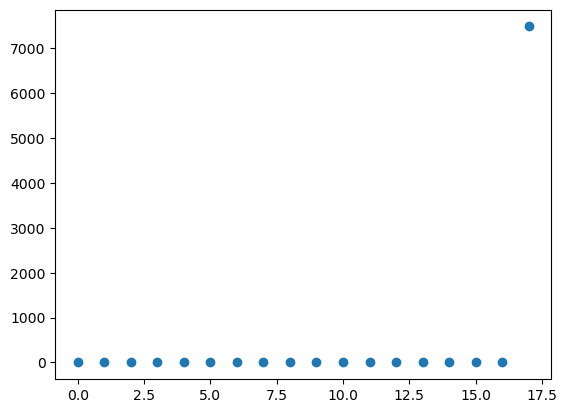

In [191]:
l=18
plt.scatter(range(l),counts_Hz[:l])

In [44]:
filenames = ["MOTStabilityChecks_20230908.tif", 
             "MOTStabilityChecks_20230908_X2.tif",
             "MOTStabilityChecks_20230908_X3.tif"]

tifstack = np.array(list(itertools.chain(*[tifffile.imread(os.path.join(images,f))
    for f in filenames
]))) # flattening tifstackList

In [54]:
len(tifstack[20*6:])%7

0

In [55]:
tifstack.shape

(20280, 301, 401)

In [134]:
lucaMOTdata = np.reshape(tifstack[20*6:],(-1,7,301,401))

In [135]:
lucaMOTdata.shape

(2880, 7, 301, 401)

In [136]:
lucadata_len = lucaMOTdata.shape[0]

we were monitoring the coil monitor outputs and zotino using the Labjack T7 and GOOD logger.
however, because the file was large, the good reader froze and I had to remote into the server
that runs origin to get the data. 

I wrote a sql command to get the data, a bashscript to run the sql command, and then ran the 
bashscript directing the output to a csv file which I obtained through an scp command. detailed notes
on how to do all this are on the wiki in origin notes.

In [309]:
origin_file = os.path.join(csvdata,"qn_labjack_data_20230908_coil_monitoring.csv")
has_header = True
with open(origin_file, 'r', newline='') as f:
    reader = csv.reader(f, delimiter='\t')
    if has_header:
        header = reader.__next__()
    data = [row for row in reader]
    f.close()

### coil data analysis

In [310]:
header

['measurement_time',
 'Ch10',
 'Ch1',
 'Ch2',
 'Ch3',
 'Ch4',
 'Ch5',
 'Ch6',
 'Ch7',
 'Ch8',
 'Ch9']

In [311]:
data = np.array(data,float).transpose()

In [312]:
data.shape

(11, 6861586)

In [314]:
# zotino y, x, top, bottom = ch3, 4, 5, 6
# coils top, bottom, x, y = 7, 8, 9, 10 monitor zotino. 
channel_map = {'Ch3':'A-Y zotino','Ch4':'A-X zotino','Ch5':'A-Zbottom zotino','Ch6':'A-Ztop zotino',
               'Ch7':'A-Zbottom monitor','Ch8':'A-Ztop monitor','Ch9':'A-X monitor','Ch10':'A-Y monitor'}

data_dict = {}
for row,channel in zip(data,header):
    data_dict[channel]=row

data_names = ['A-Ztop monitor','A-Zbottom monitor','A-X monitor','A-Y monitor',
              'A-Ztop zotino','A-Zbottom zotino','A-X zotino','A-Y  zotino',]

data_named_dict = {'time':data[0]}

for channel in header:
    if channel in channel_map.keys():
        name = channel_map[channel]
        data_named_dict[name] = data_dict[channel]

In [338]:
x = data[0][100]
dt.utcfromtimestamp(x/2**32 - 5*3600).strftime(
    '%m-%d %H:%M:%S')

'09-08 17:35:01'

In [339]:
origintime_to_dt(data[0][0]), origintime_to_dt(data[0][-1])

('09-08 17:35', '09-09 18:21')

In [341]:
26*3600/len(data[0])

0.01364116109599151

In [273]:
timestamps = [origintime_to_dt(x) for x in data[0]]

In [271]:
timestamps.shape

(5912901,)

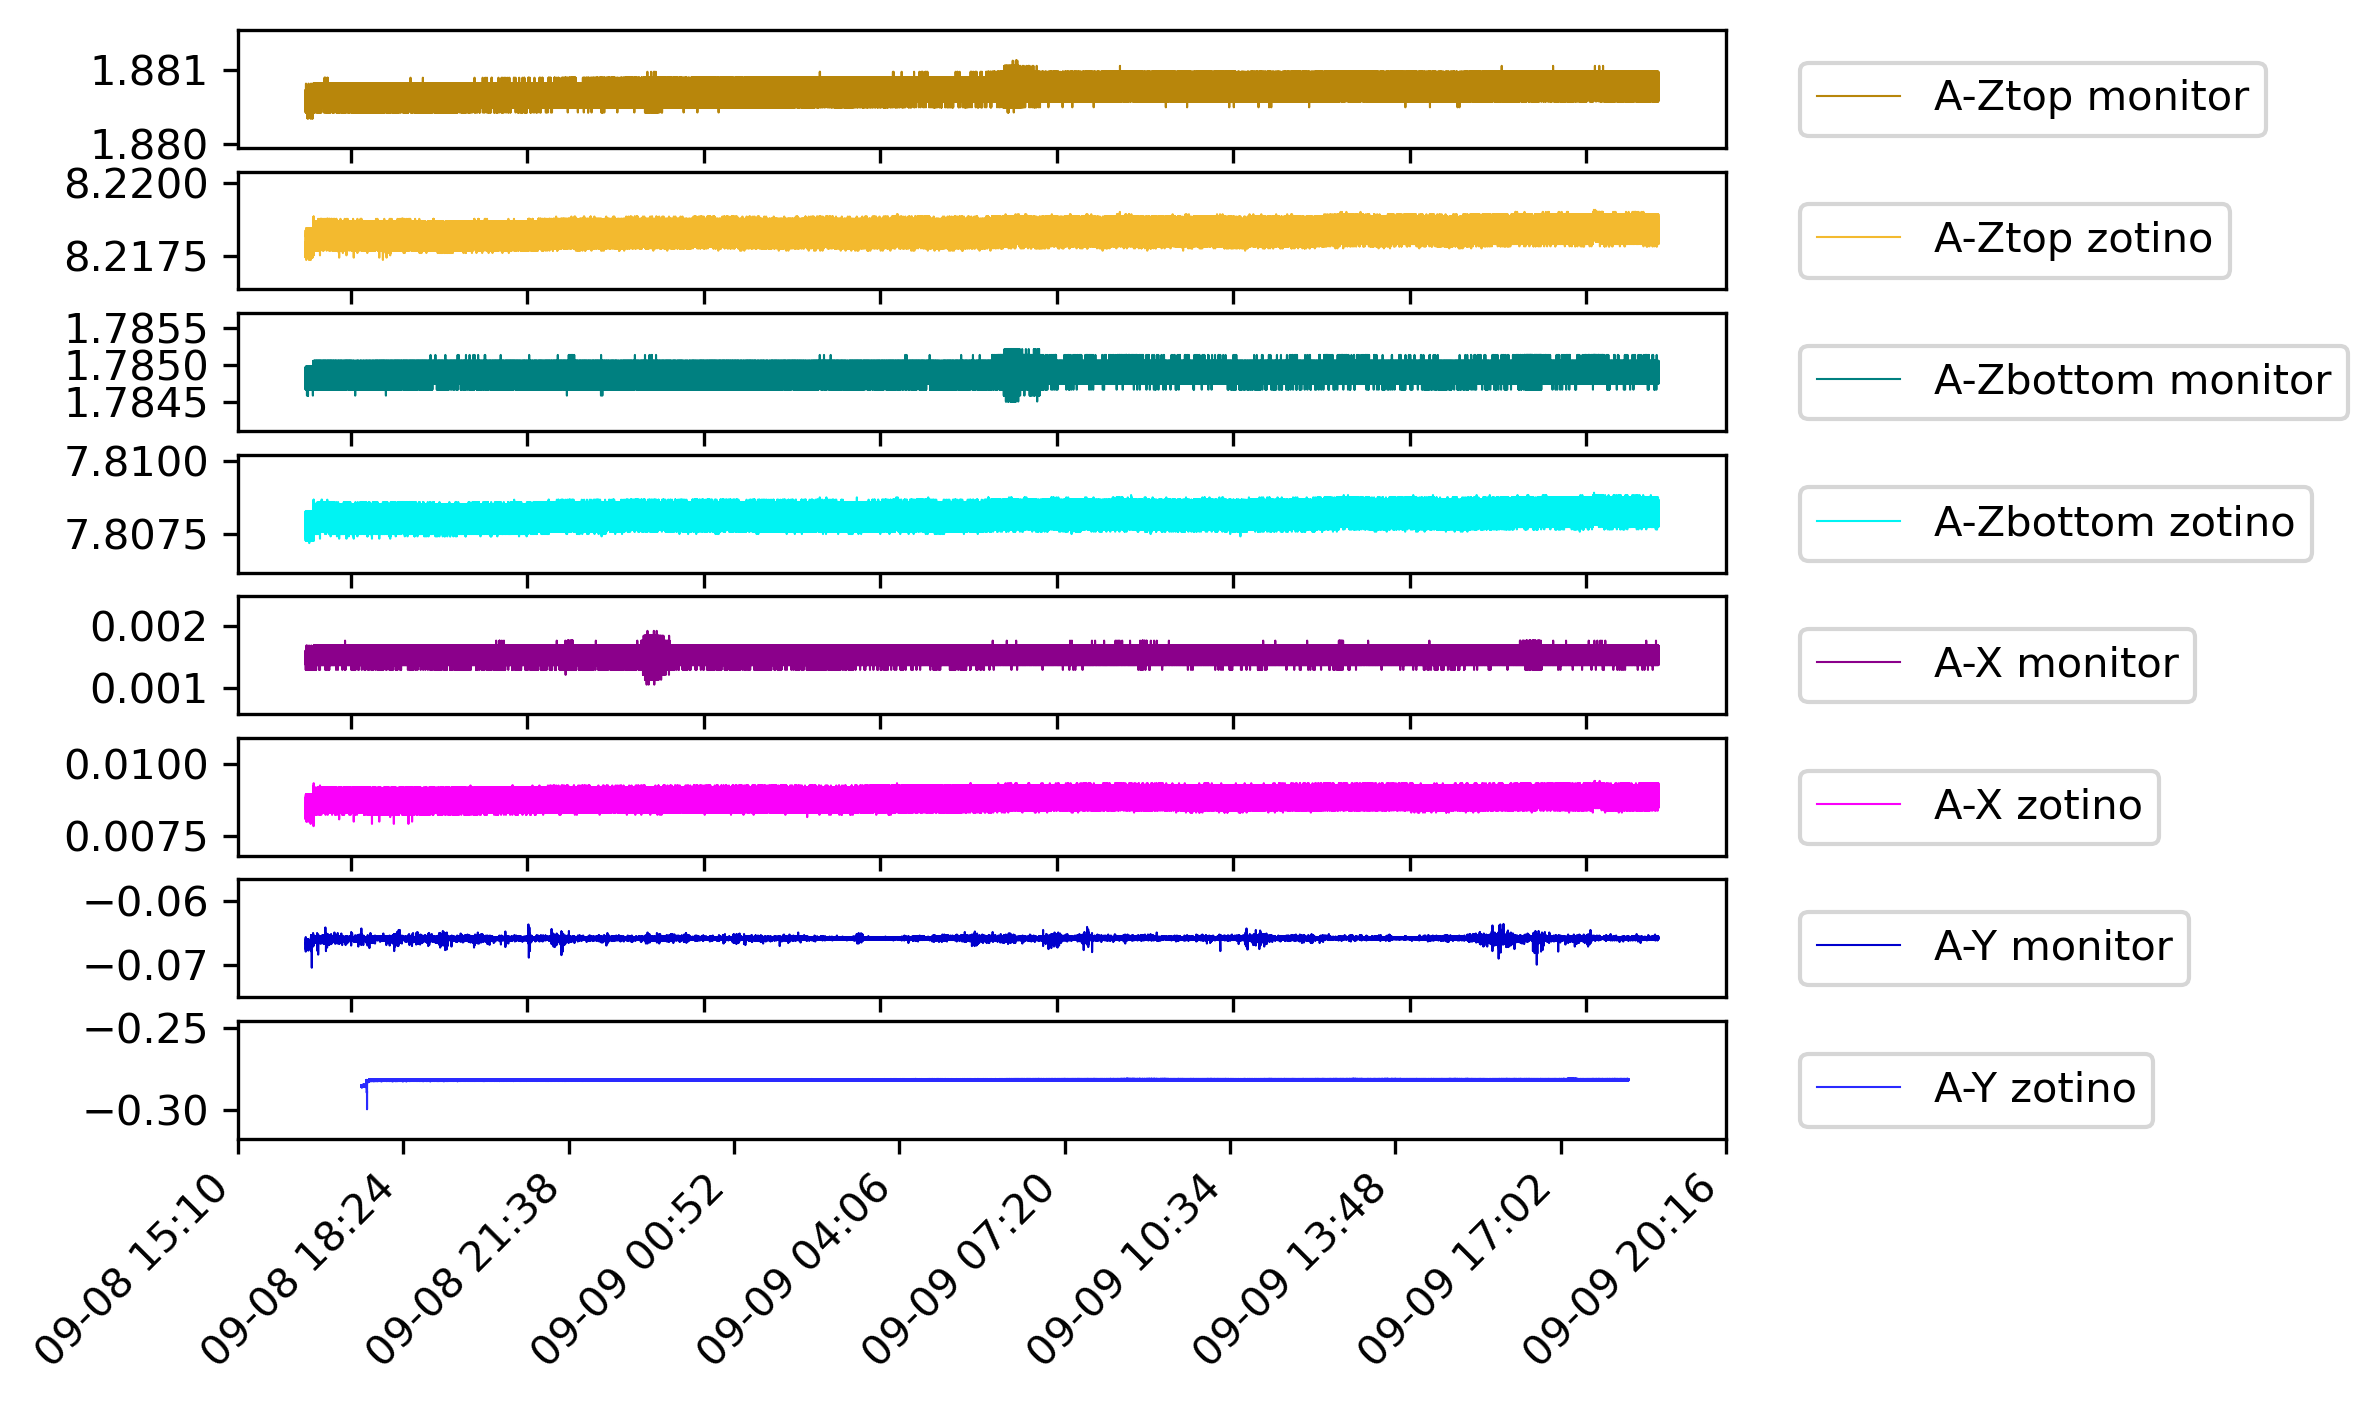

In [320]:
"""
the fluctuations here are order 1 mV, so they do not seem concerning. also, we set up the test
in such a way as to check whether several things were the cause of the noisy behavior we previously
observed.
"""

fig,axes = plt.subplots(nrows=8,dpi=300)

labels =['A-Ztop monitor','A-Ztop zotino','A-Zbottom monitor','A-Zbottom zotino',
         'A-X monitor','A-X zotino','A-Y monitor','A-Y zotino',]
colors = ['darkgoldenrod',lighten_color('darkgoldenrod',0.7),
          'teal',lighten_color('teal',0.7),
          'darkmagenta',lighten_color('darkmagenta',0.7),
          'mediumblue',lighten_color('mediumblue',0.7)]
ylims = [(4,6),(-0.1,0.1),(5,9)]
for ax,label,color in zip(axes,labels,colors):
    ax.plot(data[0], data_named_dict[label], label=label,color=color,linewidth=0.5)
    datamean = np.mean(data_named_dict[label])
    datamaxdev = max(abs(datamean - data_named_dict[label]))
    ax.set_ylim((datamean - 2*datamaxdev,datamean + 2*datamaxdev))
    ax.legend(loc=(1.05,0.1))
xticks = ax.get_xticks()
ax.set_xticks(ticks=xticks,labels=[origintime_to_dt(x) for x in xticks])
plt.xticks(rotation=45, ha='right')
plt.show()

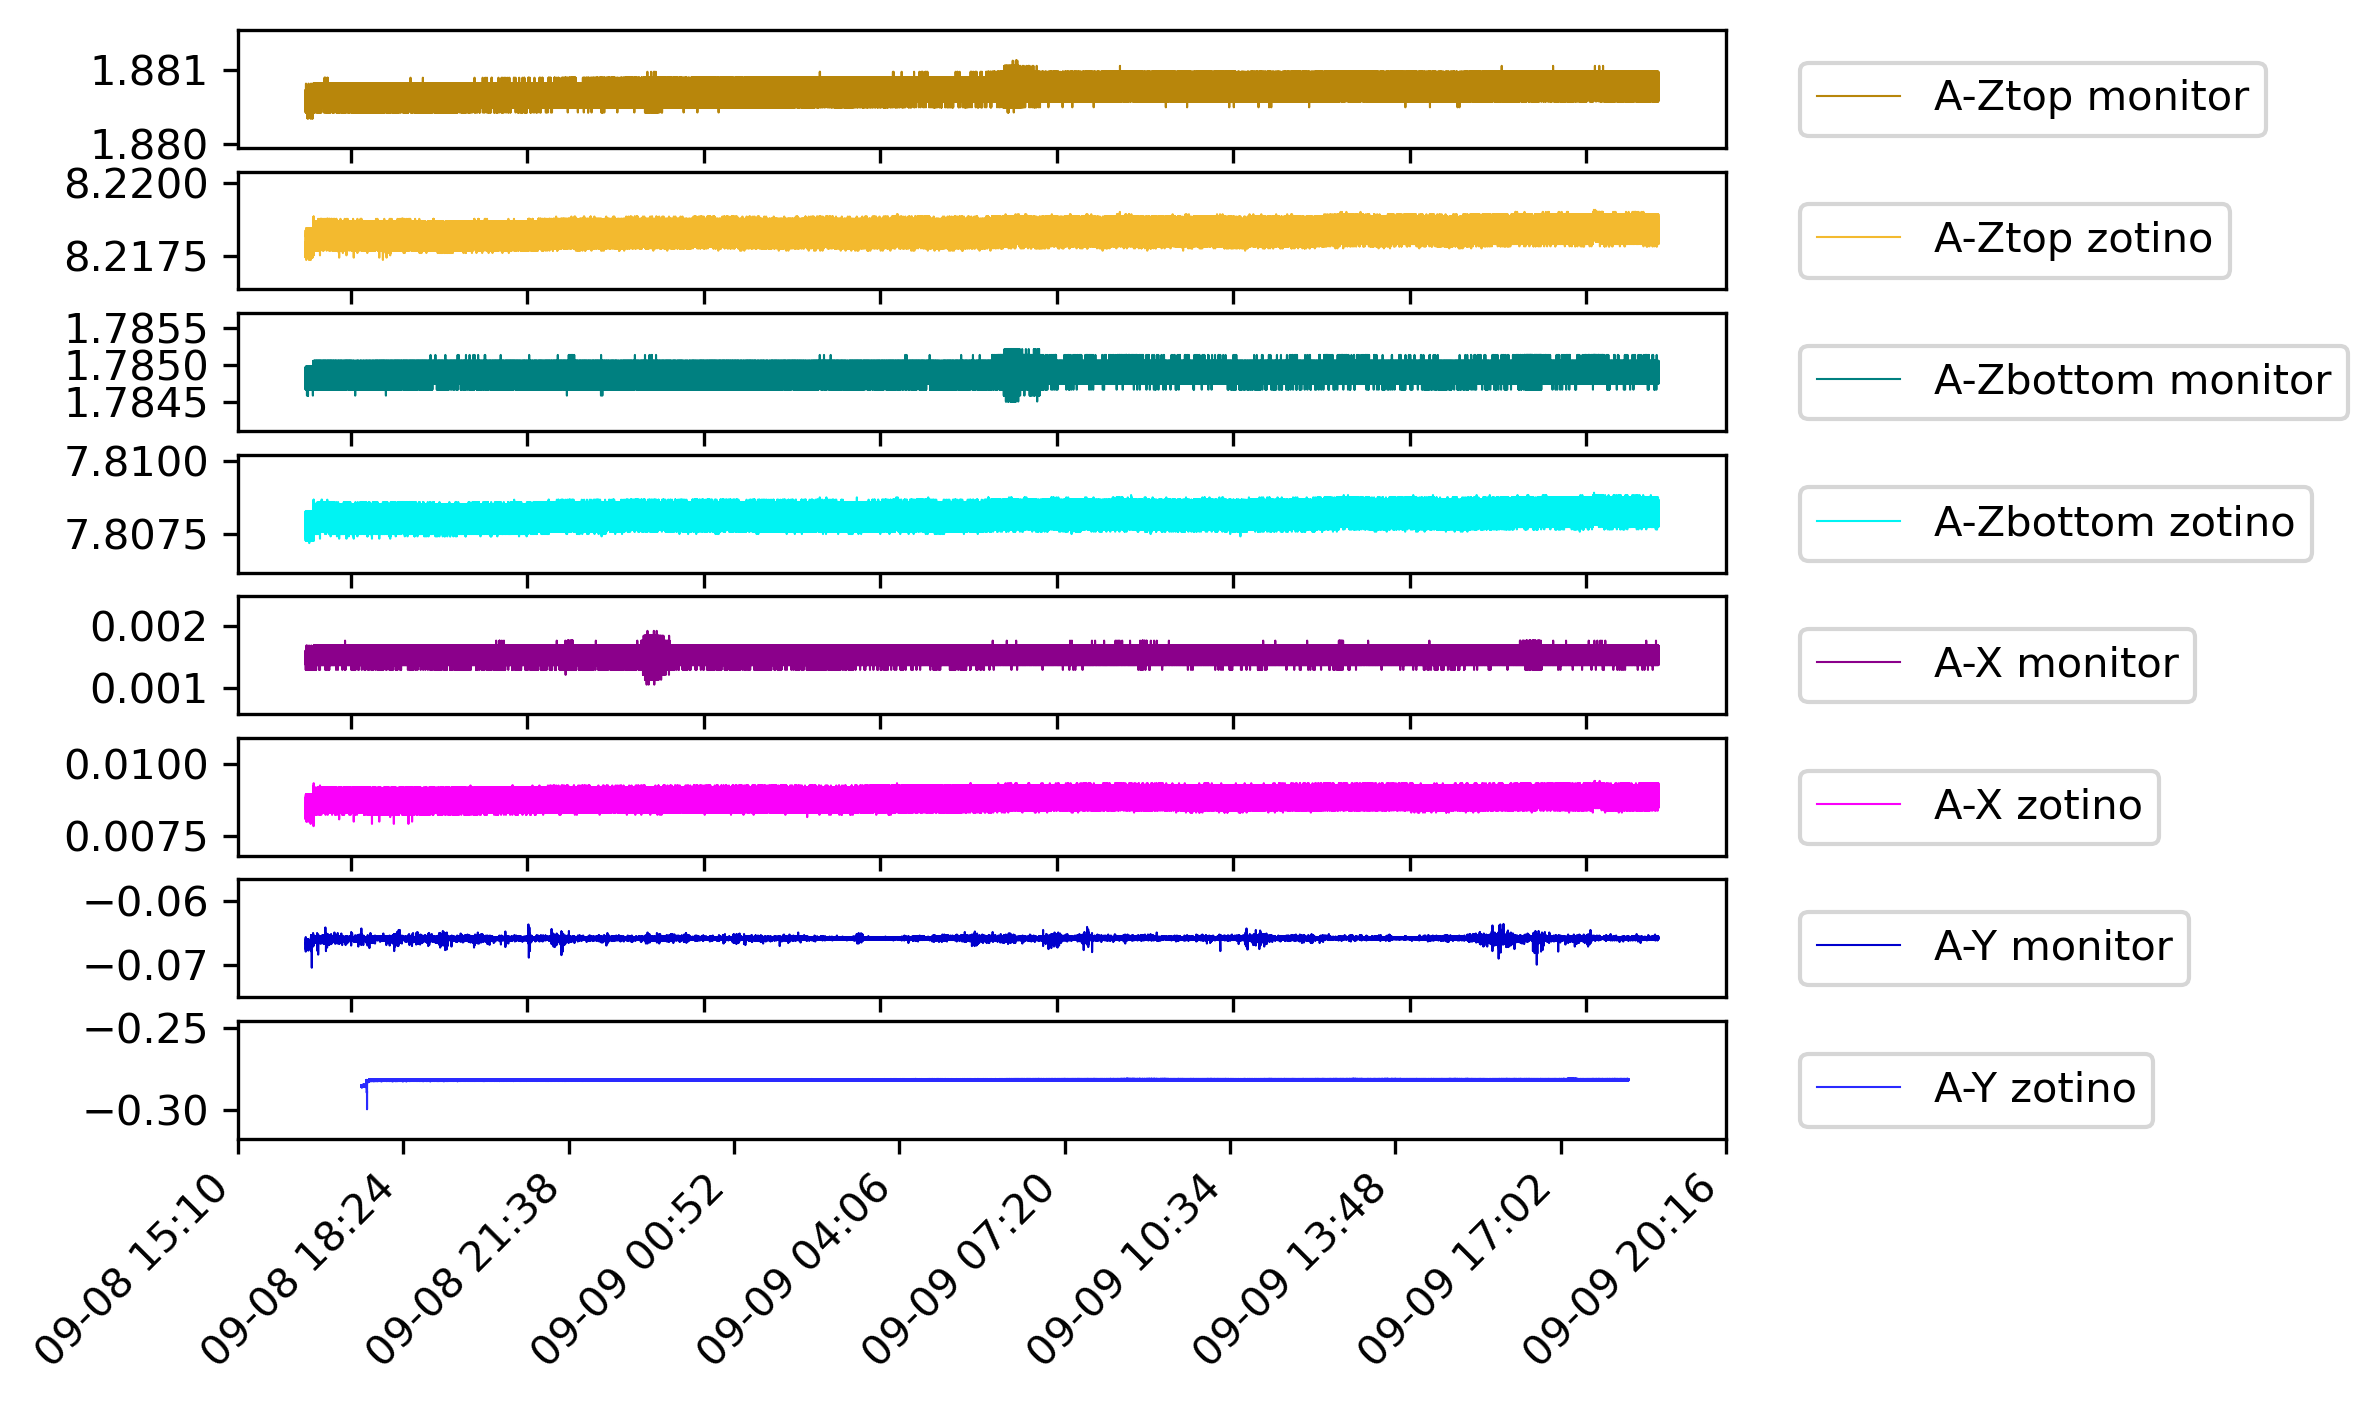

In [320]:
"""
there might be a timing problem with the GOOD logger or origin, as can be seen in the plots
below, particularly on A-Zbottom monitor and A-Y zotino. if that is real, I'm not sure what 
would cause it.
"""

fig,axes = plt.subplots(nrows=8,dpi=300)

labels =['A-Ztop monitor','A-Ztop zotino','A-Zbottom monitor','A-Zbottom zotino',
         'A-X monitor','A-X zotino','A-Y monitor','A-Y zotino',]
colors = ['darkgoldenrod',lighten_color('darkgoldenrod',0.7),
          'teal',lighten_color('teal',0.7),
          'darkmagenta',lighten_color('darkmagenta',0.7),
          'mediumblue',lighten_color('mediumblue',0.7)]
ylims = [(4,6),(-0.1,0.1),(5,9)]
for ax,label,color in zip(axes,labels,colors):
    ax.plot(data[0], data_named_dict[label], label=label,color=color,linewidth=0.5)
    datamean = np.mean(data_named_dict[label])
    datamaxdev = max(abs(datamean - data_named_dict[label]))
    ax.set_ylim((datamean - 2*datamaxdev,datamean + 2*datamaxdev))
    ax.legend(loc=(1.05,0.1))
xticks = ax.get_xticks()
ax.set_xticks(ticks=xticks,labels=[origintime_to_dt(x) for x in xticks])
plt.xticks(rotation=45, ha='right')
plt.show()

### find ROIs for the MOT beam scattering

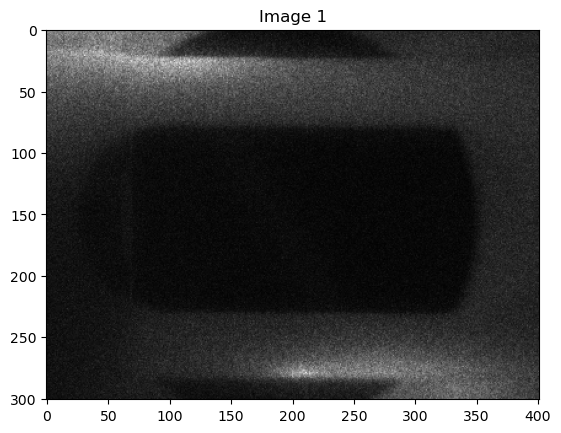

In [114]:
for i in range(1):# #7):
    image = lucaMOTdata[i,5]
    plt.imshow(image, cmap='gray')
    plt.title(f"Image {i+1}")
    plt.show()

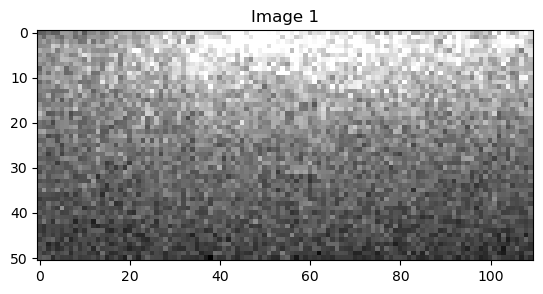

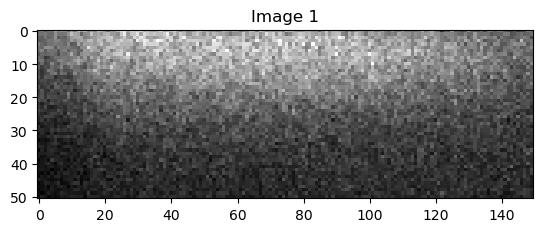

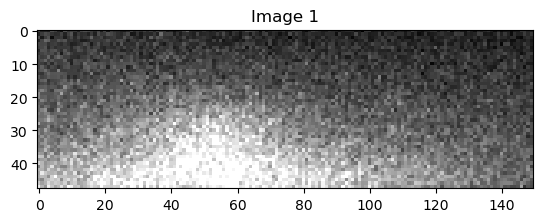

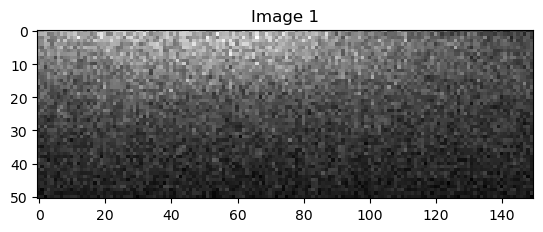

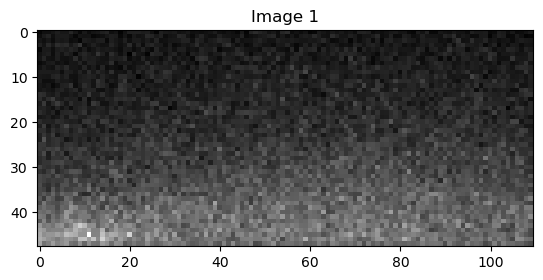

In [115]:
# use 2 ROIs, one for each strip of the macor tube where the most scattering from
# the on-chip MOT beams occurs

# MOT1
image = lucaMOTdata[i,2][24:75,200:310]
plt.imshow(image, cmap='gray')
plt.title(f"Image {i+1}")
plt.show()

# MOT2 dh=212
image = lucaMOTdata[i,3][24:75,50:200]
plt.imshow(image, cmap='gray')
plt.title(f"Image {i+1}")
plt.show()

# MOT3 
dh=212
image = lucaMOTdata[i,4][22+dh:70+dh,50:200]
plt.imshow(image, cmap='gray')
plt.title(f"Image {i+1}")
plt.show()

# scattering from MOT4 is weak, so use two ROIs
# MOT4a
image = lucaMOTdata[i,5][24:75,50:200]
plt.imshow(image, cmap='gray')
plt.title(f"Image {i+1}")
plt.show()
# MOT4b
image = lucaMOTdata[i,5][22+dh:70+dh,200:310]
plt.imshow(image, cmap='gray')
plt.title(f"Image {i+1}")
plt.show()

### plot fW, Luca, SPCM datasets alongside each other

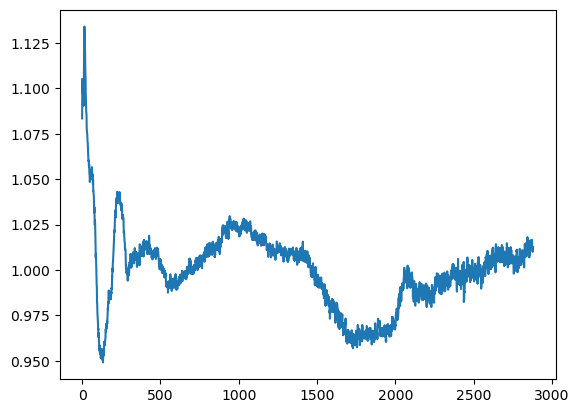

In [163]:
fig,ax = plt.subplots()
lucaMOT1data = lucaMOTdata[:,2,24:75,200:310]
ypts = np.array([np.sum(lucaMOT1data[i]) for i in range(lucadata_len)],dtype=float)
ypts /= np.mean(ypts)
xpts = range(len(ypts))
#     ax.scatter(xpts, ypts, color=color,s=0.1)
ax.plot(xpts, ypts) #, color=color, label=label,linewidth=0.5)

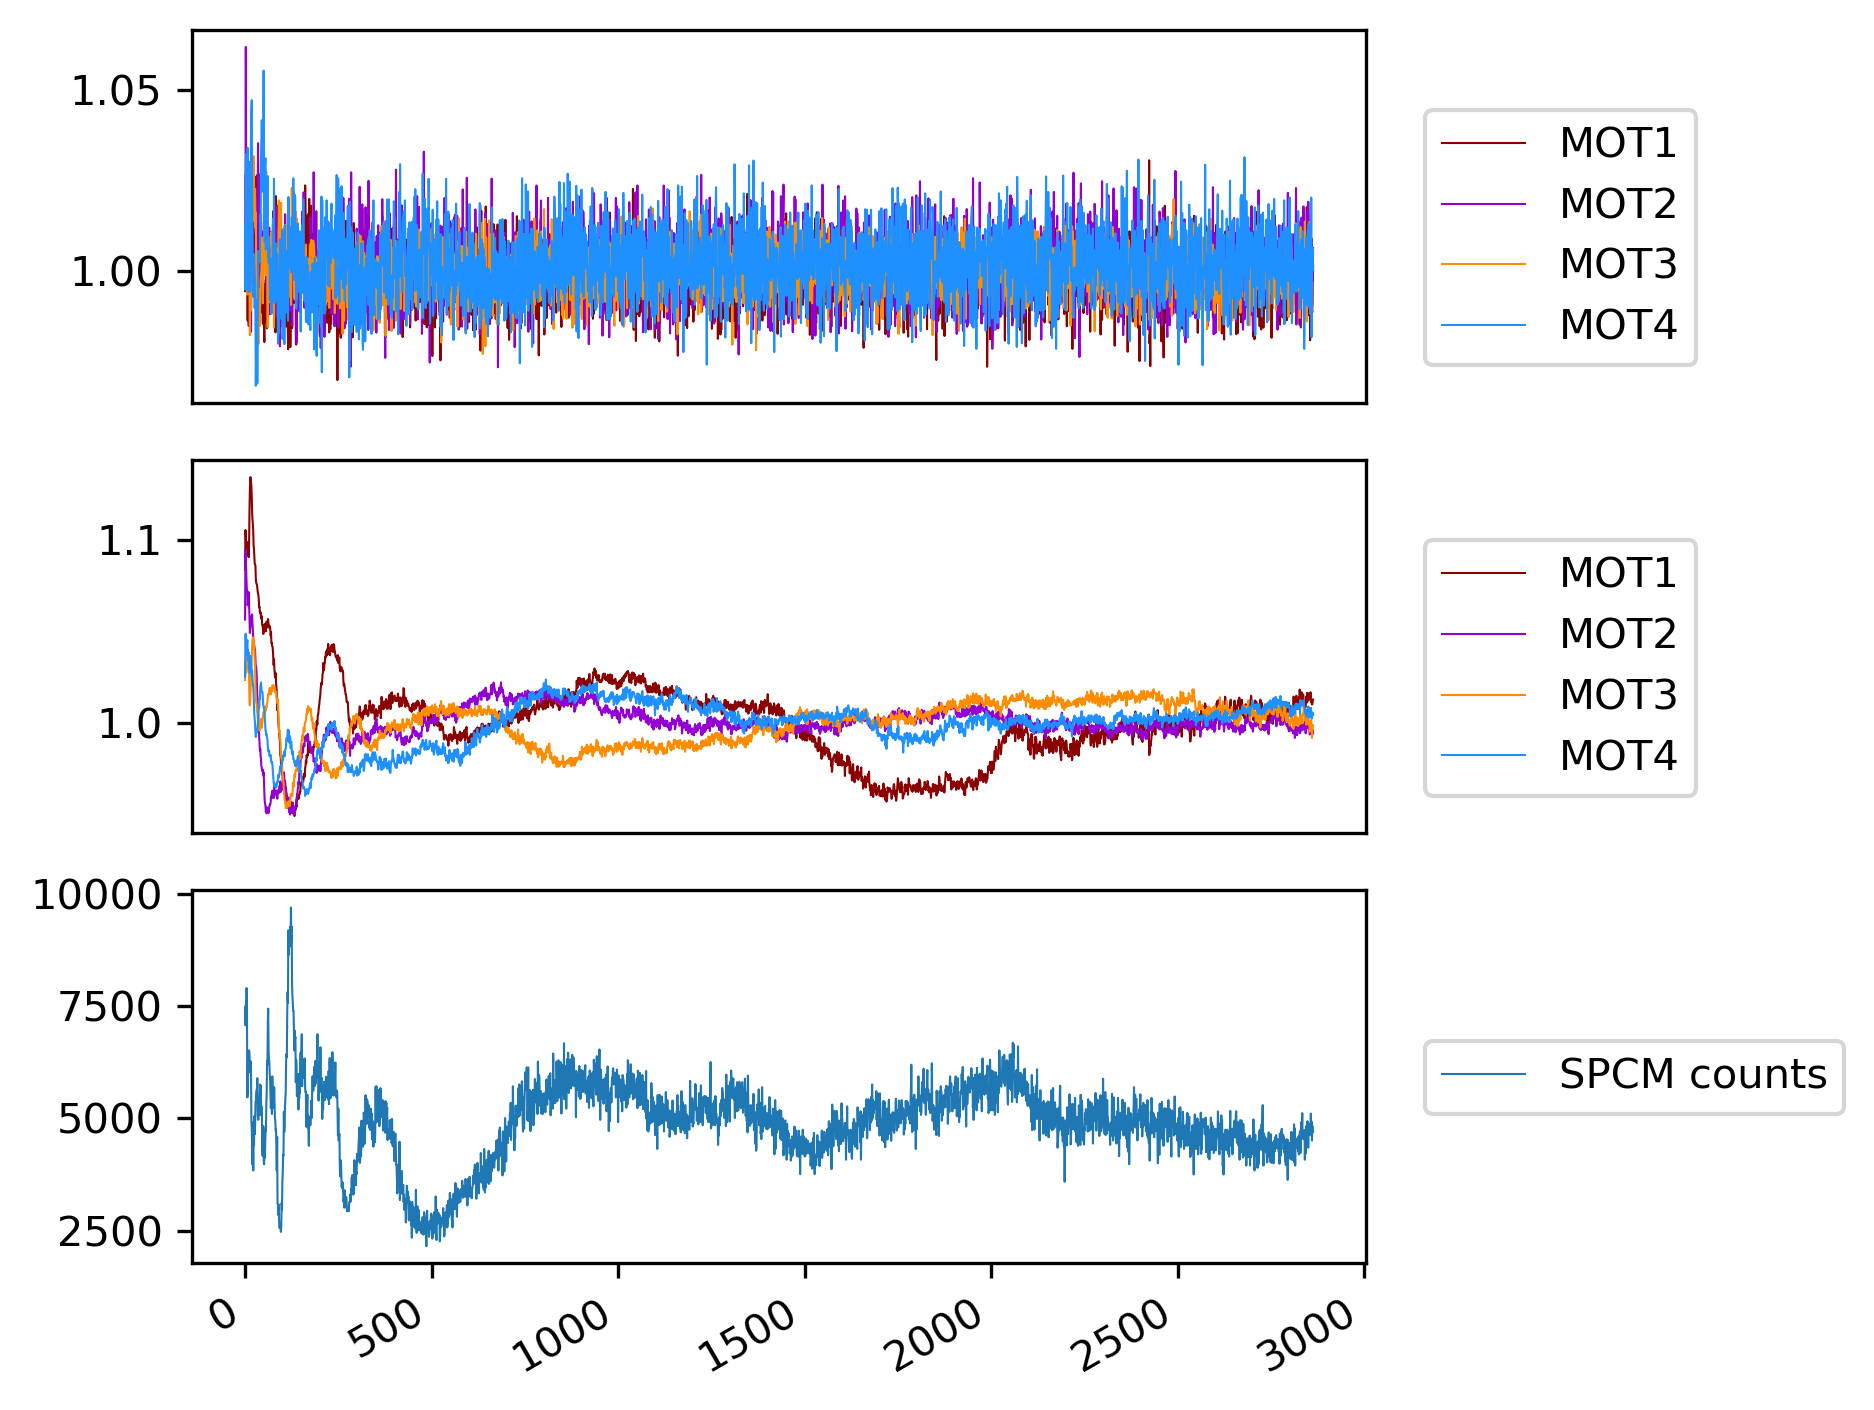

In [196]:
# fW detector data
labels = [f'MOT{i+1}' for i in range(6)]+['switchyard_in']
fig,axes = plt.subplots(nrows=3,dpi=300)
ax, ax2, ax3 = axes
colors = ['darkred','darkviolet','darkorange','dodgerblue','teal','crimson','indigo']
for label,data,color in zip(labels,MOTdata[:4],colors):
    ypts = data[20:] # the feedback runs 20 times before we start counting photons
    xpts = range(len(ypts))
#     ax.scatter(xpts, ypts, color=color,s=0.1)
    ax.plot(xpts, ypts, color=color, label=label,linewidth=0.5)
#     ax.set_ylim((0.95,1.05))
    ax.legend(loc=(1.05,0.1))
ax.get_xaxis().set_visible(False)

# Luca data - sum the scattering from the ROIs and normalize to the mean of each
colors = ['darkred','darkviolet','darkorange','dodgerblue','teal','crimson','indigo']
# for label,data,color in zip(labels,MOTdata,colors):
lucaMOT1_data = lucaMOTdata[:,2,24:75,200:310]
lucaMOT2_data = lucaMOTdata[:,3,24:75,50:200]
lucaMOT3_data = lucaMOTdata[:,4,22+dh:70+dh,50:200]
lucaMOT4a_data = lucaMOTdata[:,5,24:75,50:200]
lucaMOT4b_data = lucaMOTdata[:,5,22+dh:70+dh,200:310]

y1pts = np.array([np.sum(lucaMOT1_data[i]) for i in range(lucadata_len)],dtype=float)
y1pts /= np.mean(y1pts)
y2pts = np.array([np.sum(lucaMOT2_data[i]) for i in range(lucadata_len)],dtype=float)
y2pts /= np.mean(y2pts)
y3pts = np.array([np.sum(lucaMOT3_data[i]) for i in range(lucadata_len)],dtype=float)
y3pts /= np.mean(y3pts)
y4pts = np.array([np.sum(lucaMOT4a_data[i])+np.sum(lucaMOT4b_data[i]) 
                  for i in range(lucadata_len)],dtype=float)
y4pts /= np.mean(y4pts)
xpts = range(len(y4pts))
for i,y in enumerate([y1pts,y2pts,y3pts,y4pts]):
    ax2.plot(xpts, y, color=colors[i], label=f"MOT{i+1}", linewidth=0.5)
# ax2.set_ylim((0.95,1.05))
ax2.legend(loc=(1.05,0.1))
ax2.get_xaxis().set_visible(False)
counts_steps = len(counts_Hz)

# hr0 = 17
# min0 = 10
# timestamps = [((hr0+(min0+i)//60)%24,(min0+i)%60) for i in range(900)]

# SPCM data
ax3.plot(range(counts_steps),counts_Hz,label='SPCM counts',linewidth=0.5)
# ax2.set_xticks(timestamps)
plt.gcf().autofmt_xdate()
ax3.legend(loc=(1.05,0.4))
fig.tight_layout()

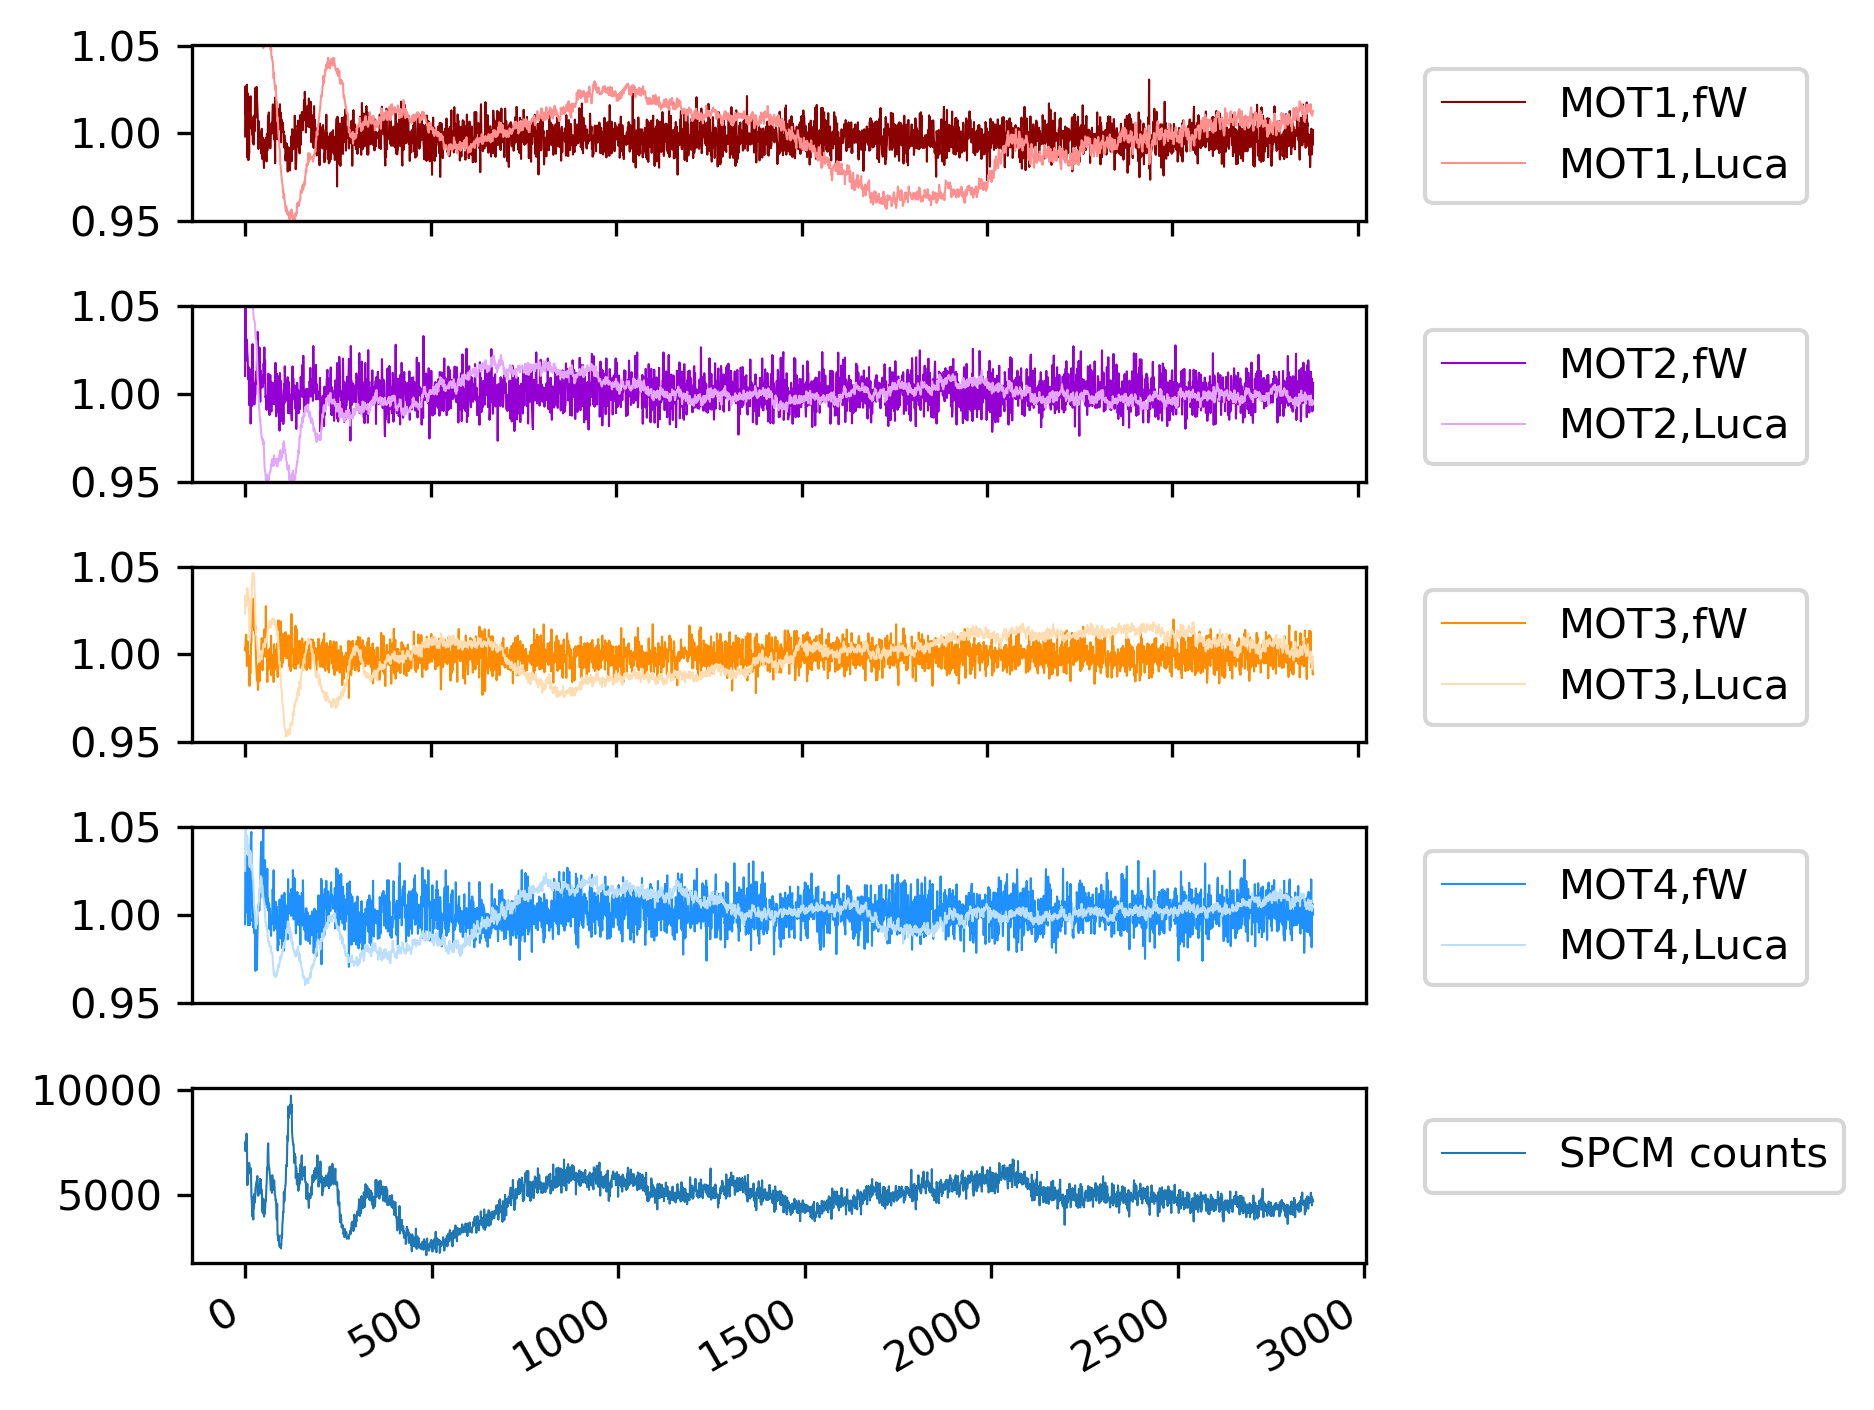

In [210]:
# plot each beam pair in its own subplot

# fW detector data
labels = [f'MOT{i+1}' for i in range(6)]+['switchyard_in']
fig,axes = plt.subplots(nrows=5,dpi=300)
MOTaxes = axes[:4]
axSPCM = axes[-1]
# colors = ['darkred','darkviolet','darkorange','dodgerblue','teal','crimson','indigo']
# for label,data,color in zip(labels,MOTdata[:4],colors):
#     ypts = data[20:] # the feedback runs 20 times before we start counting photons
#     xpts = range(len(ypts))
# #     ax.scatter(xpts, ypts, color=color,s=0.1)
#     ax.plot(xpts, ypts, color=color, label=label,linewidth=0.5)
# #     ax.set_ylim((0.95,1.05))
#     ax.legend(loc=(1.05,0.1))
# ax.get_xaxis().set_visible(False)

# Luca data - sum the scattering from the ROIs and normalize to the mean of each
colors = ['darkred','darkviolet','darkorange','dodgerblue','teal','crimson','indigo']
# for label,data,color in zip(labels,MOTdata,colors):
lucaMOT1_data = lucaMOTdata[:,2,24:75,200:310]
lucaMOT2_data = lucaMOTdata[:,3,24:75,50:200]
lucaMOT3_data = lucaMOTdata[:,4,22+dh:70+dh,50:200]
lucaMOT4a_data = lucaMOTdata[:,5,24:75,50:200]
lucaMOT4b_data = lucaMOTdata[:,5,22+dh:70+dh,200:310]

y1pts = np.array([np.sum(lucaMOT1_data[i]) for i in range(lucadata_len)],dtype=float)
y1pts /= np.mean(y1pts)
y2pts = np.array([np.sum(lucaMOT2_data[i]) for i in range(lucadata_len)],dtype=float)
y2pts /= np.mean(y2pts)
y3pts = np.array([np.sum(lucaMOT3_data[i]) for i in range(lucadata_len)],dtype=float)
y3pts /= np.mean(y3pts)
y4pts = np.array([np.sum(lucaMOT4a_data[i])+np.sum(lucaMOT4b_data[i])
                  for i in range(lucadata_len)],dtype=float)
y4pts /= np.mean(y4pts)
xpts = range(len(y4pts))
# for i,y in enumerate([y1pts,y2pts,y3pts,y4pts]):
#     ax.plot(xpts, y, color=colors[i], label=f"MOT{i+1}", linewidth=0.5)
    
for label,data_fW,data_luca,color,ax in zip(labels,MOTdata[:4],[y1pts,y2pts,y3pts,y4pts],colors,
                                         MOTaxes):
#     ypts =  # the feedback runs 20 times before we start counting photons
    xpts = range(len(data_fW[21:]))
#     ax.scatter(xpts, ypts, color=color,s=0.1)
    ax.plot(xpts, data_fW[21:], color=color, label=label+',fW',linewidth=0.5)
    ax.plot(xpts, data_luca, color=lighten_color(color,0.3), label=label+',Luca',linewidth=0.5)
    ax.set_ylim((0.95,1.05))
    ax.legend(loc=(1.05,0.1))
ax.get_xaxis().set_visible(False)
    
ax.legend(loc=(1.05,0.1))
ax.get_xaxis().set_visible(False)
counts_steps = len(counts_Hz)

# hr0 = 17
# min0 = 10
# timestamps = [((hr0+(min0+i)//60)%24,(min0+i)%60) for i in range(900)]

# SPCM data
axSPCM.plot(range(counts_steps),counts_Hz,label='SPCM counts',linewidth=0.5)
# ax2.set_xticks(timestamps)
plt.gcf().autofmt_xdate()
axSPCM.legend(loc=(1.05,0.4))
fig.tight_layout()

In [ ]:
### 

## 2023.09.01

SPCM signal with feedback on, monitored by running SamplerMOTCoilTune. I zeroed the potentiometer box and ran the code on differential mode, with the coil values set to what gave 10 kHz counts in a previous run. Note however that I was only getting ~ 8 kHz counts in the most recent run

In [2]:
f = h5py.File(os.path.join(results, '2023-08-31\\17\\000004757-SamplerMOTCoilTune.h5'))
[x for x in f['datasets'].values()]

[<HDF5 dataset "AOM_A1_power": shape (), type "<f8">,
 <HDF5 dataset "AOM_A2_power": shape (), type "<f8">,
 <HDF5 dataset "AOM_A3_power": shape (), type "<f8">,
 <HDF5 dataset "AOM_A4_power": shape (), type "<f8">,
 <HDF5 dataset "AOM_A5_power": shape (), type "<f8">,
 <HDF5 dataset "AOM_A6_power": shape (), type "<f8">,
 <HDF5 dataset "MOT1_monitor": shape (921,), type "<f8">,
 <HDF5 dataset "MOT2_monitor": shape (921,), type "<f8">,
 <HDF5 dataset "MOT3_monitor": shape (921,), type "<f8">,
 <HDF5 dataset "MOT4_monitor": shape (921,), type "<f8">,
 <HDF5 dataset "MOT5_monitor": shape (921,), type "<f8">,
 <HDF5 dataset "MOT6_monitor": shape (921,), type "<f8">,
 <HDF5 dataset "MOT_switchyard_monitor": shape (921,), type "<f8">,
 <HDF5 dataset "SPCM_count_rate_Hz": shape (180005,), type "<f8">,
 <HDF5 dataset "SPCM_max_counts_and_volts": shape (5,), type "<f8">,
 <HDF5 dataset "monitor_pts": shape (1,), type "<i4">,
 <HDF5 dataset "p_cooling_DP_MOT": shape (), type "<f8">]

In [141]:
MOTdata = [np.array(data) for data in  f['datasets'].values()][6:13]
counts_Hz = np.array(f['datasets']['SPCM_count_rate_Hz'])

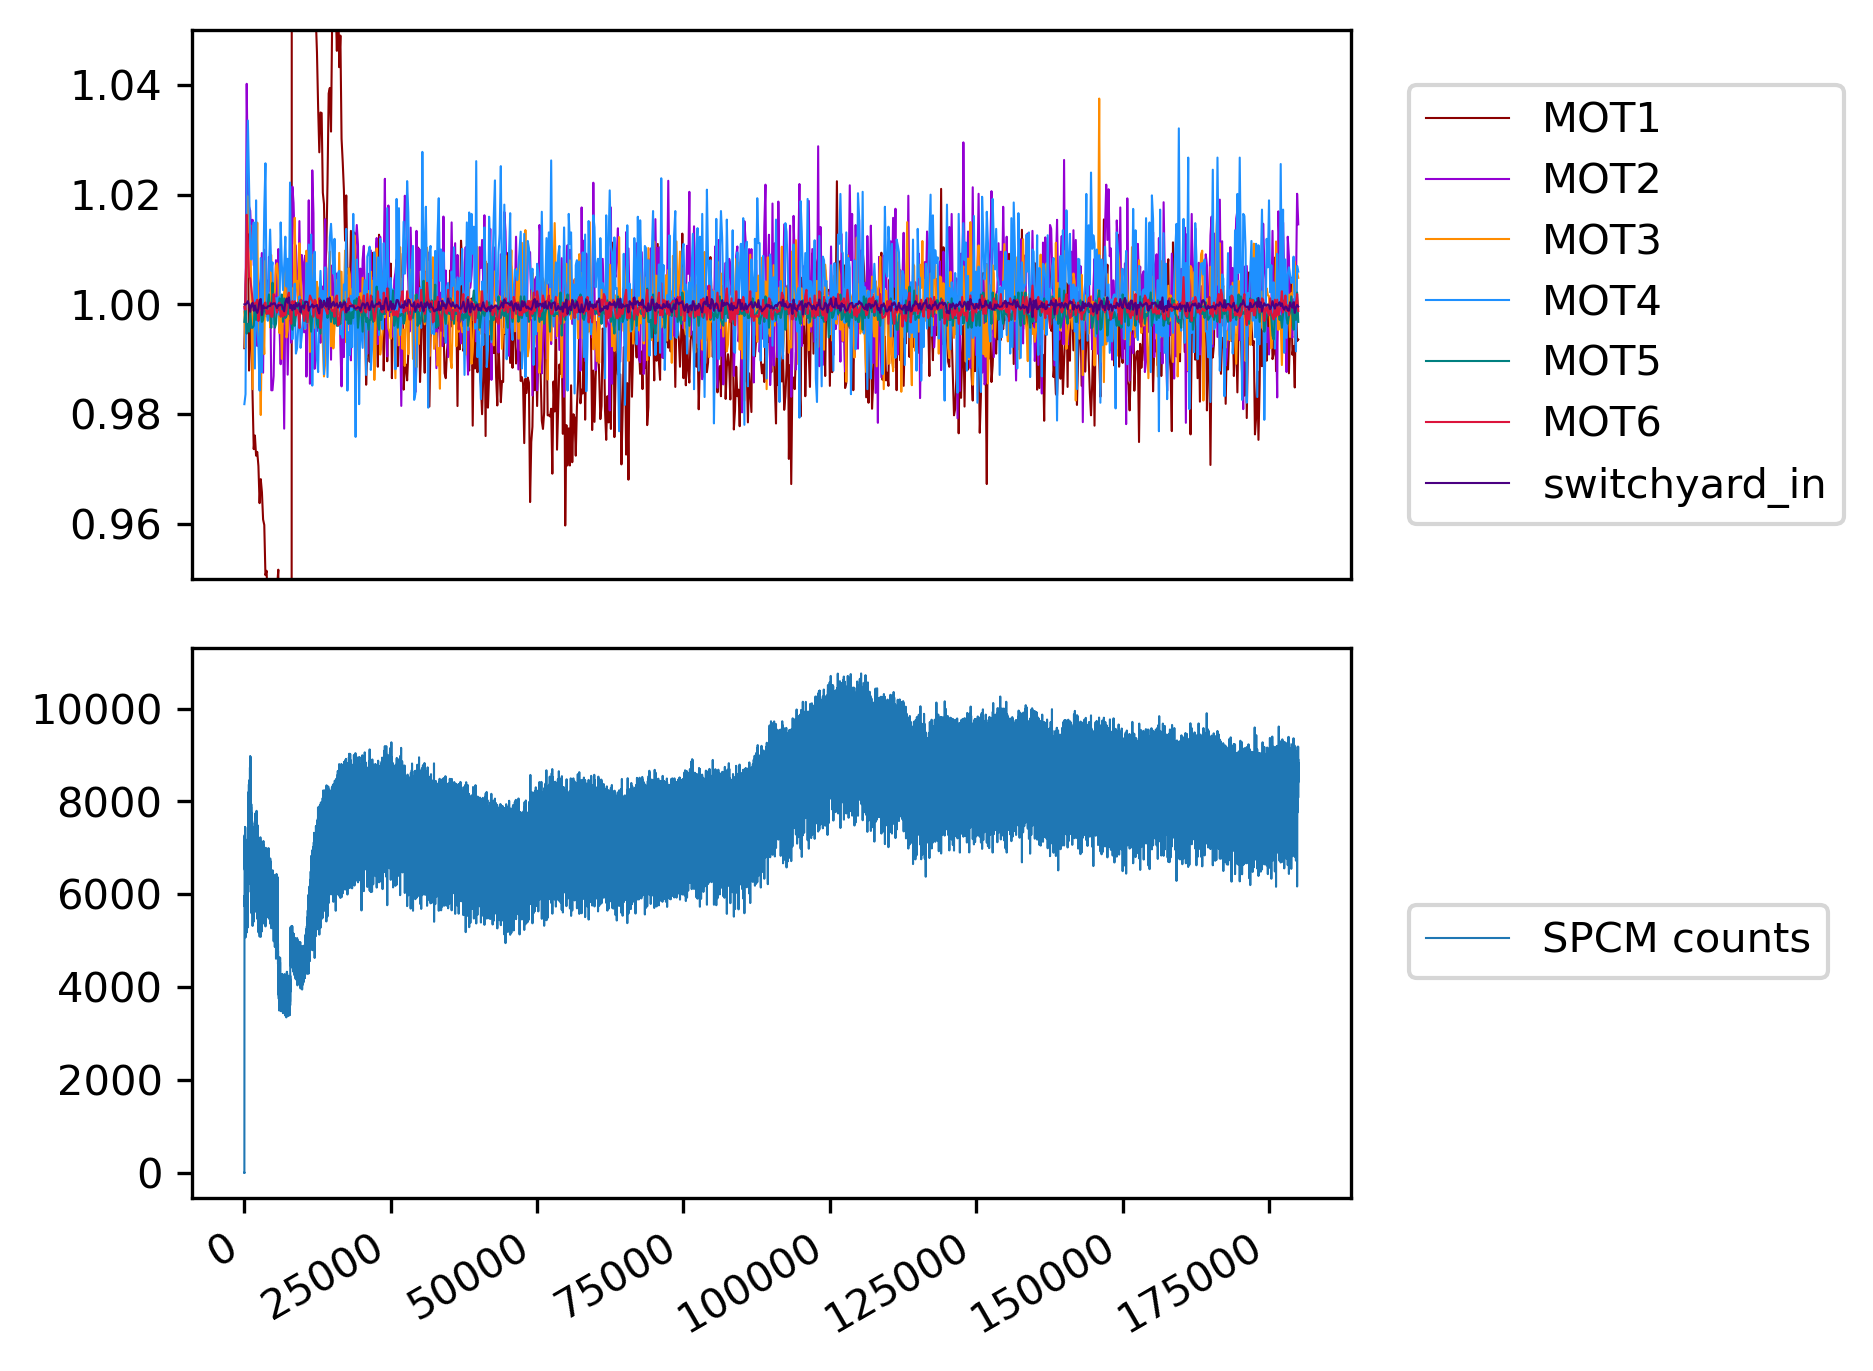

In [210]:
# the dip shown between about 30 and 500 is when I intentionally made the MOT go completely
# away by tuning the X shim, and then brought the MOT back to the same location "by hand".
# the duration of the experiment was about 10 minutes. every point showing the MOT power was
# plotted just after the feedback was run.

labels = [f'MOT{i+1}' for i in range(6)]+['switchyard_in']
fig,axes = plt.subplots(nrows=2,dpi=300)
ax, ax2 = axes
colors = ['darkred','darkviolet','darkorange','dodgerblue','teal','crimson','indigo']
for label,data,color in zip(labels,MOTdata,colors):
    ypts = data[20:] # the feedback runs 20 times before we start counting photons
    xpts = range(len(ypts))
#     ax.scatter(xpts, ypts, color=color,s=0.1)
    ax.plot(xpts, ypts, color=color, label=label,linewidth=0.5)
    ax.set_ylim((0.95,1.05))
    ax.legend(loc=(1.05,0.1))
ax.get_xaxis().set_visible(False)
counts_steps = len(counts_Hz)

hr0 = 17
min0 = 10
timestamps = [((hr0+(min0+i)//60)%24,(min0+i)%60) for i in range(900)]

ax2.plot(range(counts_steps),counts_Hz,label='SPCM counts',linewidth=0.5)
# ax2.set_xticks(timestamps)
plt.gcf().autofmt_xdate()
ax2.legend(loc=(1.05,0.4))
fig.tight_layout()

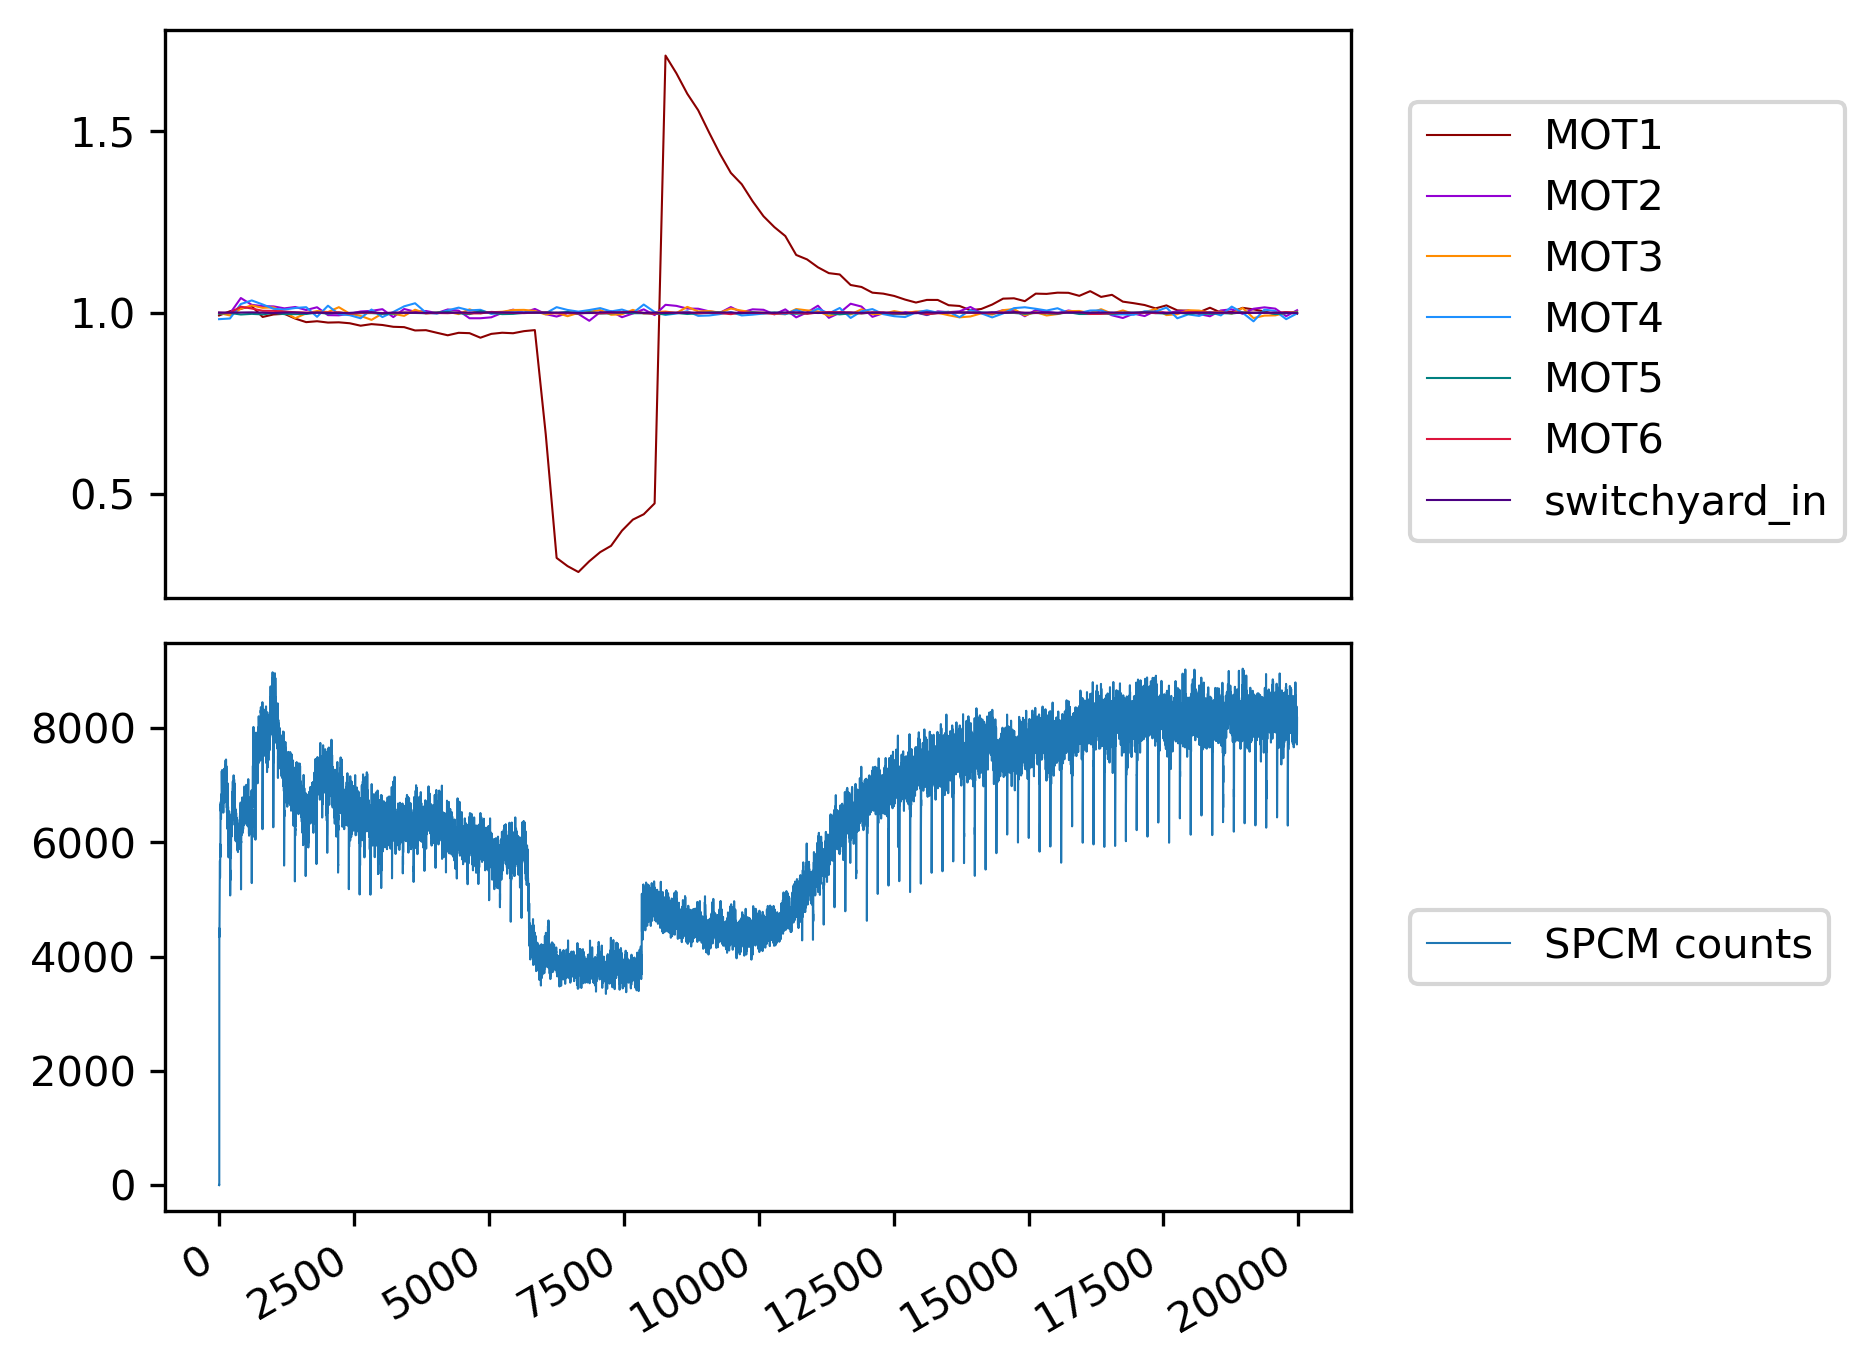

In [218]:
pts = 100
labels = [f'MOT{i+1}' for i in range(6)]+['switchyard_in']
fig,axes = plt.subplots(nrows=2,dpi=300)
ax, ax2 = axes
colors = ['darkred','darkviolet','darkorange','dodgerblue','teal','crimson','indigo']
for label,data,color in zip(labels,MOTdata,colors):
    ypts = data[20:pts+20] # the feedback runs 20 times before we start counting photons
    xpts = range(len(ypts))
#     ax.scatter(xpts, ypts, color=color,s=0.1)
    ax.plot(xpts, ypts, color=color, label=label,linewidth=0.5)
#     ax.set_ylim((0.95,1.05))
    ax.legend(loc=(1.05,0.1))
ax.get_xaxis().set_visible(False)
counts_steps = int(len(counts_Hz)*pts/len(data[20:])) #len(counts_Hz)

ax2.plot(range(counts_steps),counts_Hz[:counts_steps],label='SPCM counts',linewidth=0.5)
plt.gcf().autofmt_xdate()
ax2.legend(loc=(1.05,0.4))
fig.tight_layout()

In [223]:
n = 1500 #len(counts_Hz)
(0.314*n+(n//200)*0.1)/60

7.861666666666666

## 2023.08.31

SPCM signal with feedback on, monitored by running SamplerMOTCoilTune. I zeroed the potentiometer box and ran the code on differential mode, with the coil values set to what gave 10 kHz counts in a previous run.

In [110]:
f = h5py.File(os.path.join(results, '2023-08-31\\15\\000004752-SamplerMOTCoilTune.h5'))
[x for x in f['datasets'].values()]

[<HDF5 dataset "AOM_A1_power": shape (), type "<f8">,
 <HDF5 dataset "AOM_A2_power": shape (), type "<f8">,
 <HDF5 dataset "AOM_A3_power": shape (), type "<f8">,
 <HDF5 dataset "AOM_A4_power": shape (), type "<f8">,
 <HDF5 dataset "AOM_A5_power": shape (), type "<f8">,
 <HDF5 dataset "AOM_A6_power": shape (), type "<f8">,
 <HDF5 dataset "MOT1_monitor": shape (31,), type "<f8">,
 <HDF5 dataset "MOT2_monitor": shape (31,), type "<f8">,
 <HDF5 dataset "MOT3_monitor": shape (31,), type "<f8">,
 <HDF5 dataset "MOT4_monitor": shape (31,), type "<f8">,
 <HDF5 dataset "MOT5_monitor": shape (31,), type "<f8">,
 <HDF5 dataset "MOT6_monitor": shape (31,), type "<f8">,
 <HDF5 dataset "MOT_switchyard_monitor": shape (31,), type "<f8">,
 <HDF5 dataset "SPCM_count_rate_Hz": shape (2005,), type "<f8">,
 <HDF5 dataset "SPCM_max_counts_and_volts": shape (5,), type "<f8">,
 <HDF5 dataset "monitor_pts": shape (1,), type "<i4">,
 <HDF5 dataset "p_cooling_DP_MOT": shape (), type "<f8">]

In [111]:
MOTdata = [np.array(data) for data in  f['datasets'].values()][6:13]
counts_Hz = np.array(f['datasets']['SPCM_count_rate_Hz'])

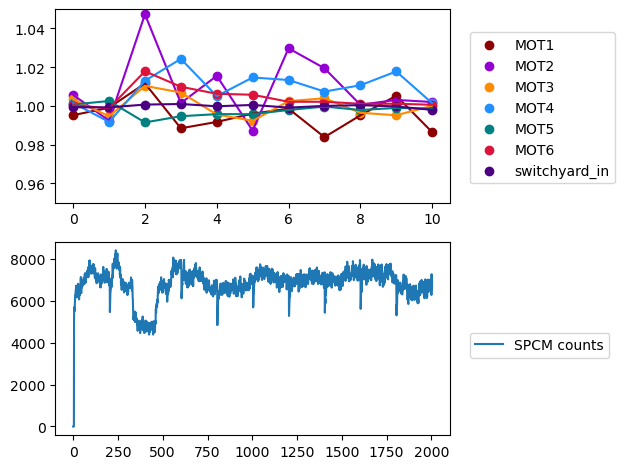

In [138]:
# the dip shown between about 30 and 500 is when I intentionally made the MOT go completely
# away by tuning the X shim, and then brought the MOT back to the same location "by hand".
# the duration of the experiment was about 10 minutes. every point showing the MOT power was
# plotted just after the feedback was run.

labels = [f'MOT{i+1}' for i in range(6)]+['switchyard_in']
fig,axes = plt.subplots(nrows=2)
ax, ax2 = axes
colors = ['darkred','darkviolet','darkorange','dodgerblue','teal','crimson','indigo']
for label,data,color in zip(labels,MOTdata,colors):
    ypts = data[20:] # the feedback runs 20 times before we start counting photons
    xpts = range(len(ypts))
    ax.scatter(xpts, ypts, label=label, color=color)
    ax.plot(xpts, ypts, color=color)
    ax.set_ylim((0.95,1.05))
    ax.legend(loc=(1.05,0.1))
ax2.plot(range(len(counts_Hz)),counts_Hz,label='SPCM counts')
ax2.legend(loc=(1.05,0.4))
fig.tight_layout()